# **US Census Data**

In [ ]:
!pip install tensorflow
!pip install scikeras
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
import shap
import matplotlib.pyplot as plt

In [ ]:
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

## **Step 1: Data Preprocessing**

In [ ]:
train_data = pd.read_csv('USCensusTraining.csv')
test_data = pd.read_csv('USCensusTest.csv')

### **1.1 Remove One Attribute**
Education and education-num essentially measure the same concept. Remove education and treat education-num as an ordinal categorical variable.

In [ ]:
# education
train_data['education'].value_counts()

,count
education,
HS-grad,8120
Some-college,5597
Bachelors,4140
Masters,1300
Assoc-voc,1059
11th,909
Assoc-acdm,801
10th,721
7th-8th,491


In [ ]:
# education-num
train_data['education-num'].value_counts()

,count
education-num,
9,8120
10,5597
13,4140
14,1300
11,1059
7,909
12,801
6,721
4,491


In [ ]:
train_drop = train_data.drop(columns=['education'])
test_drop = test_data.drop(columns=['education'])

### **1.2 Dealing with Missing Values**
- The datasets are now called train_drop and test_drop.
- Handle missing values ('?' in nominal categorical variables, 99999 in numerical variables)
- Consolidate certain levels to reduce the number of dummy variables generated.
- Combine capital gain and capital loss into one variable

In [ ]:
# helper function: replace ? with proportional distribution for a categorical variable
def deal_with_missing(df, variable):

  df[variable] = df[variable].replace('?', np.nan)
  value_counts = df[variable].value_counts(normalize=True)
  missing = df[df[variable].isna()].index
  filled_values = np.random.choice(value_counts.index, size=len(missing), p=value_counts.values)
  df.loc[missing, variable] = filled_values

  return df

**workclass**

In [ ]:
train_drop['workclass'].value_counts()

,count
workclass,
Private,17385
Self-emp-not-inc,1978
Local-gov,1624
?,1399
State-gov,993
Self-emp-inc,857
Federal-gov,750
Without-pay,9
Never-worked,5


In [ ]:
# workclass
# Merge without-pay, never-worked into Private (mode class)
# replace ? with proportional distribution for workclass

def deal_with_workclass(df):
  df['workclass'] = df['workclass'].replace(['Without-pay', 'Never-worked'],
                                            df['workclass'].mode()[0])
  return deal_with_missing(df, 'workclass')

train_clean = deal_with_workclass(train_drop)
test_clean = deal_with_workclass(test_drop)
train_clean['workclass'].value_counts()

,count
workclass,
Private,18426
Self-emp-not-inc,2094
Local-gov,1714
State-gov,1057
Self-emp-inc,910
Federal-gov,799


**marital-status**

In [ ]:
train_clean['marital-status'].value_counts()

,count
marital-status,
Married-civ-spouse,11441
Never-married,8225
Divorced,3435
Separated,786
Widowed,769
Married-spouse-absent,328
Married-AF-spouse,16


In [ ]:
# marital-status
# Merge Married-AF-spouse into mode class
train_clean['marital-status'] = train_clean['marital-status'].replace(['Married-AF-spouse'],
                                                                      train_clean['marital-status'].mode()[0])
test_clean['marital-status'] = test_clean['marital-status'].replace(['Married-AF-spouse'],
                                                                    test_clean['marital-status'].mode()[0])
train_clean['marital-status'].value_counts()

,count
marital-status,
Married-civ-spouse,11457
Never-married,8225
Divorced,3435
Separated,786
Widowed,769
Married-spouse-absent,328


**occupation**

In [ ]:
train_clean['occupation'].value_counts()

,count
occupation,
Prof-specialty,3180
Craft-repair,3122
Exec-managerial,3084
Adm-clerical,2975
Sales,2815
Other-service,2555
Machine-op-inspct,1536
?,1404
Transport-moving,1228


In [ ]:
# occupation
# Merge Armed-Force into mode class
# replace ? with proportional distribution for occupation

def deal_with_occupation(df):

  df['occupation'] = df['occupation'].replace(['Armed-Forces'], df['occupation'].mode()[0])

  return deal_with_missing(df, 'occupation')

train_clean = deal_with_occupation(train_clean)
test_clean = deal_with_occupation(test_clean)
train_clean['occupation'].value_counts()

,count
occupation,
Prof-specialty,3384
Craft-repair,3289
Exec-managerial,3282
Adm-clerical,3161
Sales,2968
Other-service,2715
Machine-op-inspct,1627
Transport-moving,1303
Handlers-cleaners,1060


**capital-gain and capital-loss**

In [ ]:
# capital-gain has 126 missing values
# capital-loss has 0 missing values
print('Missing values in capital-gain:', train_clean.loc[train_clean['capital-gain'] == 99999].shape[0])
print('Missing values in capital-loss:', train_clean.loc[train_clean['capital-loss'] == 99999].shape[0])

Missing values in capital-gain: 126
Missing values in capital-loss: 0


In [ ]:
# When capital-gain is missing, capital-loss is 0 as well
print(train_clean.loc[train_clean['capital-gain'] == 99999]['capital-loss'].value_counts())

# When capital-gain has values, capital-loss is 0
print(train_clean.loc[train_clean['capital-gain'] != 0]['capital-loss'].value_counts())

# When capital-loss has values, capital-gain is 0
print(train_clean.loc[train_clean['capital-loss'] != 0]['capital-gain'].value_counts())

capital-loss
0    126
Name: count, dtype: int64
capital-loss
0    2076
Name: count, dtype: int64
capital-gain
0    1156
Name: count, dtype: int64


In [ ]:
# create a new variable capital-net
# If capital-gain is missing, capital-net is 0
# If capital-loss has values, capital-net is negative capital-loss
# If capital-gain has values, capital-net is capital-gain
def deal_with_capital(df):
  df['capital-net'] = 0
  df.loc[df['capital-loss'] != 0, 'capital-net'] = -df.loc[df['capital-loss'] != 0, 'capital-loss']
  df.loc[~df['capital-gain'].isin([0, 99999]), 'capital-net'] = df.loc[~df['capital-gain'].isin([0, 99999]), 'capital-gain']
  df.drop(columns=['capital-gain', 'capital-loss'], inplace=True)
  return df

train_clean = deal_with_capital(train_clean)
test_clean = deal_with_capital(test_clean)

In [ ]:
train_clean['capital-net'].describe()

,capital-net
count,25000.000000
mean,498.084160
std,2598.832402
min,-4356.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,41310.000000


**native-country**

In [ ]:
# native-country has 42 levels, with US having most of the data
print("levels of native-country:", len(train_clean['native-country'].unique()))
print("US has:", train_clean[train_clean['native-country'] == 'United-States'].shape[0], "out of 25000")

levels of native-country: 42
US has: 22421 out of 25000


In [ ]:
# native-country: fill missing values using United-States
train_clean['native-country'] = train_clean['native-country'].replace('?', 'United-States')
test_clean['native-country'] = test_clean['native-country'].replace('?', 'United-States')

In [ ]:
# except for United-States and Mexico, group countries by continent to reduce levels
europe = ["England", "Germany", "Italy", "Poland",
          "Portugal", "France", "Yugoslavia", "Scotland",
          "Greece", "Ireland", "Hungary", "Holand-Netherlands"]

asia = ["India", "Iran", "Philippines", "Cambodia", "Thailand",
         "Laos", "Taiwan", "China", "Japan", "Vietnam", "Hong"]

# A level called "South" has 64 values - ambiguous country
# merge it into America
america = ["Cuba", "Jamaica", "Puerto-Rico", "Honduras", "Canada",
           "Haiti", "Dominican-Republic", "El-Salvador", "Guatemala",
           "Nicaragua", "Trinadad&Tobago", "Outlying-US(Guam-USVI-etc)",
           "South", "Columbia", "Ecuador", "Peru"]

def deal_with_native_country(df):

    df['native-origin'] = df['native-country']

    df.loc[df['native-country'].isin(europe), 'native-origin'] = 'Europe'
    df.loc[df['native-country'].isin(asia), 'native-origin'] = 'Asia'
    df.loc[df['native-country'].isin(america), 'native-origin'] = 'America'

    df.drop(columns=['native-country'], inplace=True)
    return df


train_clean = deal_with_native_country(train_clean)
test_clean = deal_with_native_country(test_clean)

In [ ]:
train_clean['native-origin'].value_counts()

,count
native-origin,
United-States,22866
America,743
Asia,503
Mexico,488
Europe,400


### **1.3 Input and Output Encoding**
- The datasets are now called train_clean and test_clean.

In [ ]:
print(train_clean.shape)
print(test_clean.shape)

(25000, 13)
(7561, 12)


**Dummy variables**

In [ ]:
# Nominal variables that need to convert into dummy variables:
# workclass, marital-status, occupation, relationship, race, sex, native-origin
# target variable: income
columns = ['workclass', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'native-origin']
train_encoded = pd.get_dummies(train_clean, columns=columns, drop_first=True)
test_encoded = pd.get_dummies(test_clean, columns=columns, drop_first=True)
train_encoded['income'] = train_encoded['income'].map({'<=50K.': 0, '>50K.': 1})
train_encoded = train_encoded.astype(int)
test_encoded = test_encoded.astype(int)

print(train_encoded.shape)
print(test_encoded.shape)

(25000, 42)
(7561, 41)


**Normalization**

In [ ]:
# use min-max normalization
# numeric and ordinal variables that need to be standardized:
# age, demogweight, education-num, capital-net, hours-per-week
scaler = preprocessing.MinMaxScaler()
columns = ['age', 'demogweight', 'education-num', 'capital-net', 'hours-per-week']
train_encoded[columns] = scaler.fit_transform(train_encoded[columns])
test_encoded[columns] = scaler.transform(test_encoded[columns])

In [ ]:
print("Inputs and output are all between 0 and 1 (train data):",
      train_encoded.apply(lambda col: col.between(0, 1).all()).all())
print("Inputs and output are all between 0 and 1 (test data):",
      test_encoded.apply(lambda col: col.between(0, 1).all()).all())

Inputs and output are all between 0 and 1 (train data): True
Inputs and output are all between 0 and 1 (test data): True


## **Step 2: Fit ANN Model**
- The final clean datasets are called train_encoded and test_encoded.
- train_encoded consists of 41 predictors and 1 output variable, and will be utilized for model construction in Steps 2 to 6.
- test_encoded contains 41 predictors and will be used for final predictions in Step 7.
- **To fit the model and evaluate its predictive performance, we will perform an additional train-test split on train_encoded.**

In [ ]:
# train test split -> 80%:20%
X_train, X_test, y_train, y_test = train_test_split(train_encoded.drop(columns=['income']),
                                                    train_encoded['income'],
                                                    test_size=0.2,
                                                    random_state=random_state)

In [ ]:
# using gridsearch CV
param_grid = {
    'batch_size':[64, 128],
    'epochs': [10, 20],
    'model__neurons': [32, 64],
    'model__activation': ['relu', 'sigmoid'],
    'optimizer': ['RMSprop', 'Adam']
}

In [ ]:
def create_model(neurons=32, activation='relu', optimizer='Adam'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(41,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model=create_model, verbose=2)

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
313/313 - 2s - 8ms/step - accuracy: 0.8043 - loss: 0.4250
Epoch 2/20
313/313 - 2s - 5ms/step - accuracy: 0.8298 - loss: 0.3643
Epoch 3/20
313/313 - 0s - 1ms/step - accuracy: 0.8363 - loss: 0.3517
Epoch 4/20
313/313 - 0s - 1ms/step - accuracy: 0.8410 - loss: 0.3432
Epoch 5/20
313/313 - 0s - 1ms/step - accuracy: 0.8440 - loss: 0.3379
Epoch 6/20
313/313 - 1s - 2ms/step - accuracy: 0.8458 - loss: 0.3347
Epoch 7/20
313/313 - 0s - 1ms/step - accuracy: 0.8475 - loss: 0.3325
Epoch 8/20
313/313 - 1s - 2ms/step - accuracy: 0.8486 - loss: 0.3309
Epoch 9/20
313/313 - 1s - 2ms/step - accuracy: 0.8486 - loss: 0.3295
Epoch 10/20
313/313 - 1s - 2ms/step - accuracy: 0.8494 - loss: 0.3284
Epoch 11/20
313/313 - 1s - 2ms/step - accuracy: 0.8498 - loss: 0.3273
Epoch 12/20
313/313 - 0s - 1ms/step - accuracy: 0.8497 - loss: 0.3263
Epoch 13/20
313/313 - 1s - 2ms/step - accuracy: 0.8500 - loss: 0.3254
Epoch 14/20
313/313 - 1s - 2ms/step - accuracy: 0.8501 - loss: 0.3245
Epoch 15/20
313/313 - 0s - 1m

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.848250 using {'batch_size': 64, 'epochs': 20, 'model__activation': 'relu', 'model__neurons': 64, 'optimizer': 'RMSprop'}


**Optimal model:**
- batch_size = 64, epochs = 20, activation = 'relu', neurons = 64, optimizer = 'Adam'
- Estimated $Accuracy_{test}$ using 5-fold cross-validation: 0.848
- Fit the model using the optimal parameters with the entire X_train, y_train

In [ ]:
optimal_model = Sequential()
# hidden layer after input layer (neurons): 64
# activation function is relu
# optimizer is Adam
optimal_model.add(Dense(64, input_shape=(41,), activation='relu'))
optimal_model.add(Dense(1, activation='sigmoid'))
optimal_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# epochs = 20, batch_size = 64
optimal_model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6974 - loss: 0.5309
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8292 - loss: 0.3685
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8371 - loss: 0.3542
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8434 - loss: 0.3433
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8476 - loss: 0.3362
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8500 - loss: 0.3318
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8527 - loss: 0.3290
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8532 - loss: 0.3271
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8543 - loss: 0.3256
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8546 - loss: 0.3244
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8555 - loss: 0.3234
Epoch 12/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

## **Step3: Identifying Important Variables (Sensitivity Analysis)**
- the optimal model fitted by partial `train_encoded` (X_train, y_train) is called `optimal_model`
- Generate a new observation $X_{mean}$, with each attribute value in $X_{mean}$ equal to the mean of the various attribute values for all records in the test set (X_test)



In [ ]:
X_test_mean = X_test.mean()
output_mean = optimal_model.predict(X_test_mean.values.reshape(1, -1))
print(output_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.19444254]]


- Attribute by attribute, vary $X_{mean}$ to reflect the attribute minimum and maximum. Find the network output for each variation and compare it to $output_{mean}$.

In [ ]:
# helper function: vary the mean value to max and min for a given attribute
def max_min_variation(mean_input, mean_output, attribute):

  attribute_max = X_test[attribute].max()
  attribute_min = X_test[attribute].min()

  mean_input[attribute] = attribute_max
  output_max = float(optimal_model.predict(mean_input.values.reshape(1, -1)))

  mean_input[attribute] = attribute_min
  output_min = float(optimal_model.predict(mean_input.values.reshape(1, -1)))

  return (output_max - float(mean_output),
          output_min - float(mean_output),
          output_max - output_min)

In [ ]:
result_list = []

for attribute in X_test.columns:
    max_variation, min_variation, max_min = max_min_variation(X_test_mean.copy(),
                                                              output_mean, attribute)

    result_list.append({
        'Attribute': attribute,
        'Max vs. Mean': round(abs(max_variation), 3),
        'Min vs. Mean': round(abs(min_variation), 3),
        'Max vs. Min': round(abs(max_min), 3)
    })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<ipython-input-152-5404e8185b63>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_max = float(optimal_model.predict(mean_input.values.reshape(1, -1)))
<ipython-input-152-5404e8185b63>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_min = float(optimal_model.predict(mean_input.values.reshape(1, -1)))
<ipython-input-152-5404e8185b63>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return (output_max - float(mean_output),
<ipython-input-152-5404e8185

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

- Identify important variables that varying form their minimum to their mmaximum will have a greater effect on the resulting network output
- `Max vs. Mean` stands for output compared with mean_output after varying the attribute to its maximum value
- `Min vs. Mean` stands for output change compared with mean_output after varying the attribute to its minimum value
- `Max vs. Min` stands for max_output compared with min_output
- `'Max vs. Mean'` + `'Min vs. Mean'` = `'Max vs. Min'`

In [ ]:
result_df = pd.DataFrame(result_list)
result_df.sort_values(by=['Max vs. Min'], ascending=False)

,Attribute,Max vs. Mean,Min vs. Mean,Max vs. Min
4,capital-net,0.804,0.139,0.943
2,education-num,0.430,0.184,0.614
3,hours-per-week,0.446,0.146,0.591
0,age,0.200,0.123,0.323
29,relationship_Own-child,0.176,0.064,0.240
27,relationship_Not-in-family,0.142,0.077,0.219
30,relationship_Unmarried,0.169,0.035,0.204
21,occupation_Priv-house-serv,0.194,0.006,0.200
6,workclass_Private,0.051,0.146,0.197
28,relationship_Other-relative,0.174,0.008,0.183


## **Step4: Predictive Performance**
- the optimal model fitted by partial `train_encoded` (X_train, y_train) is called `optimal_model`
- Assess predictive performance (classification summary, etc.) using X_test, y_test

###  Confusion Matrix

In [ ]:
y_pred_probs = optimal_model.predict(X_test)

# Convert probabilities to binary class labels (threshold = 0.5)
y_pred = (y_pred_probs > 0.5).astype(int)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


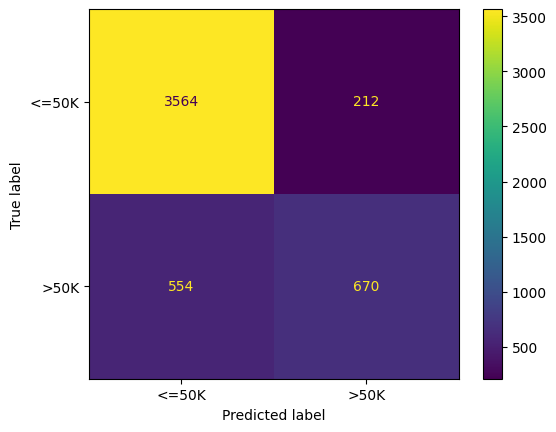

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='viridis')

In [ ]:
TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN)  # True Positive Rate
specificity = TN / (TN + FP)  # True Negative Rate
fpr = FP / (FP + TN)          # False Positive Rate
fnr = FN / (TP + FN)          # False Negative Rate

print(f"Sensitivity (Recall/TPR): {sensitivity:.4f}")
print(f"Specificity (TNR): {specificity:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

Sensitivity (Recall/TPR): 0.5474
Specificity (TNR): 0.9439
False Positive Rate (FPR): 0.0561
False Negative Rate (FNR): 0.4526


More False Negatives (FN): Individuals earning >50K are mistakenly predicted as ≤50K. This could lead to banks denying credit or loans to eligible individuals. For banks, this is a conservative error, as it avoids lending to risky applicants but may hurt customer acquisition. Fewer False Positives (FP): Fewer individuals earning ≤50K are mistakenly approved for loans as >50K, protecting the bank from financial risk. Overall, The model is more prone to False Negatives (FN), which protects banks by reducing financial risks but hurts loan applicants who genuinely qualify.

**54%** of individuals earning >50K were correctly identified by the model.
**94.36%** of individuals earning ≤50K were correctly classified.

### Classification Report (Accuracy, Precision, F1, ROC AUC)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8438
Precision: 0.7508
F1 Score: 0.6293


* 84.48% of all predictions made by the model (both for ≤50K and >50K) were correct.
* 75.63% of individuals predicted to earn >50K actually earn >50K.
* 63.01% represents the balance between how well the model identifies actual >50K earners (recall) and how often its >50K predictions are correct (precision).

ROC-AUC Score: 0.8968


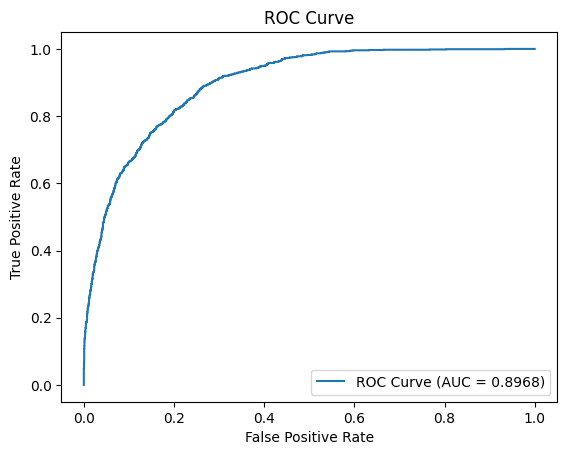

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

model has an 89.71% probability of correctly ranking a randomly chosen >50K earner higher than a randomly chosen ≤50K earner.

## **Step5: Categorical Predictors**
- the optimal model fitted by the entire `train_encoded` is called `optimal_model_entire`
- the optimal model fitted by partial `train_encoded` (X_train, y_train) is called `optimal_model`
- The available nominal categorical predictors include (dummy variables generated): workclass, marital-status, occupation, relationship, race, sex, native-origin
- The available ordinal categorical predictor: education-num

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
test_df = X_test
test_df['y_pred']=y_pred

In [ ]:
test_df

,age,demogweight,education-num,hours-per-week,capital-net,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-origin_Asia,native-origin_Europe,native-origin_Mexico,native-origin_United-States,y_pred
6868,0.205479,0.078599,0.533333,0.193878,0.095388,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
24016,0.027397,0.381675,0.533333,0.275510,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
9668,0.191781,0.251343,0.400000,0.397959,0.095388,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
13640,0.397260,0.102064,0.866667,0.500000,0.095388,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
14018,0.000000,0.216831,0.466667,0.295918,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,0.068493,0.076510,0.600000,0.438776,0.095388,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
11839,0.342466,0.123332,0.600000,0.397959,0.095388,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0
4013,0.041096,0.090757,0.600000,0.142857,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
21147,0.301370,0.228356,0.600000,1.000000,0.042504,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0


In [ ]:
categorical_variables = test_df.columns.values[5:-1]
categorical_variables

array(['workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Other',
       'race_White', 'sex_Male', 'native-origin_Asia',
       'native-orig

Note that for all categorical variables, max = 1, min = 0

In [ ]:
change_in_categorical_vars = []

for var in categorical_variables:
    min_val = test_df[var].min()
    max_val = test_df[var].max()
    max_df = test_df[test_df[var]== max_val]
    min_df = test_df[test_df[var]== min_val]

    max_income_ge50_pct = round(max_df[max_df["y_pred"] == 1].shape[0]/max_df.shape[0]*100, 3)
    min_income_ge50_pct = round(min_df[min_df["y_pred"] == 1].shape[0]/min_df.shape[0]*100, 3)

    change_in_categorical_vars.append({
        'Col_names': var,
        'Max value': max_val,
        'Min value': min_val,
        'Percentage of Income > 50k for maximum': max_income_ge50_pct,
        'Percentage of Income > 50k for minimum': min_income_ge50_pct,
        'Change in target variables when encoding changes': abs(min_income_ge50_pct-max_income_ge50_pct)
    })

change_in_categorical_vars = pd.DataFrame(change_in_categorical_vars)

From the table below, we can see that there's a big change in the income classification (whether or not > 50k) for **occupations** being one of the below or not:
- Executives at managerial level (change by ~35%)
- Prof-specialty (change by ~22%)

This is intuitive as these positions tend to make more money in real world.

In [ ]:
change_in_categorical_vars.sort_values(by=['Change in target variables when encoding changes'], ascending=False)

,Col_names,Max value,Min value,Percentage of Income > 50k for maximum,Percentage of Income > 50k for minimum,Change in target variables when encoding changes
2,workclass_Self-emp-inc,1,0,55.208,16.161,39.047
11,occupation_Exec-managerial,1,0,48.228,13.100,35.128
5,marital-status_Married-civ-spouse,1,0,36.599,1.836,34.763
7,marital-status_Never-married,1,0,1.153,25.776,24.623
17,occupation_Prof-specialty,1,0,36.806,14.339,22.467
26,relationship_Wife,1,0,38.462,16.519,21.943
24,relationship_Own-child,1,0,0.000,20.890,20.890
22,relationship_Not-in-family,1,0,3.071,22.974,19.903
15,occupation_Other-service,1,0,0.530,19.847,19.317
25,relationship_Unmarried,1,0,1.365,19.523,18.158


In [ ]:
actual_age = []
actual_edu_num = []
for ind in test_df.index:
    actual_age.append({'Actual age': train_data.iloc[[ind]]['age'].values[0]})
    actual_edu_num.append({'Actual number of education years': train_data.iloc[[ind]]['education-num'].values[0]})

actual_age = pd.DataFrame(actual_age).to_numpy()
actual_edu_num = pd.DataFrame(actual_edu_num).to_numpy()

test_df["Actual age"] = actual_age
test_df["Actual number of education years"] = actual_edu_num

test_df

,age,demogweight,education-num,hours-per-week,capital-net,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native-origin_Asia,native-origin_Europe,native-origin_Mexico,native-origin_United-States,y_pred,Actual age,Actual number of education years
6868,0.205479,0.078599,0.533333,0.193878,0.095388,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,32,9
24016,0.027397,0.381675,0.533333,0.275510,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,19,9
9668,0.191781,0.251343,0.400000,0.397959,0.095388,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,31,7
13640,0.397260,0.102064,0.866667,0.500000,0.095388,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,46,14
14018,0.000000,0.216831,0.466667,0.295918,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,17,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,0.068493,0.076510,0.600000,0.438776,0.095388,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,22,10
11839,0.342466,0.123332,0.600000,0.397959,0.095388,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,42,10
4013,0.041096,0.090757,0.600000,0.142857,0.095388,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,20,10
21147,0.301370,0.228356,0.600000,1.000000,0.042504,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,39,10


In [ ]:
distinct_age = test_df['Actual age'].unique()
change_in_ages = []

for age in distinct_age:
    age_df = test_df[test_df['Actual age']== age]

    income_ge50_pct = round(age_df[age_df["y_pred"] == 1].shape[0]/age_df.shape[0]*100, 3)

    change_in_ages.append({
        'Ages': age,
        'Percentage of Income > 50k at this age': income_ge50_pct
    })

change_in_ages = pd.DataFrame(change_in_ages)

Below table indicates that people older than 40 years old tend to have a higher percentage of predicted income over $50,000. This is intuitive too as the elder the people, the broader horizon they have and more skills they learned, the more money they will earn.

In [ ]:
pd.set_option('display.max_rows', None)
change_in_ages.sort_values(by=['Percentage of Income > 50k at this age'], ascending=False)

,Ages,Percentage of Income > 50k at this age
61,79,40.000
60,68,40.000
40,57,38.333
21,42,35.345
33,45,34.579
49,44,33.636
46,53,32.143
45,61,31.373
9,65,31.250
17,50,31.183


In [ ]:
distinct_edu_num = test_df['Actual number of education years'].unique()
change_in_edu_num = []

for edu_num in distinct_edu_num:
    edu_num_df = test_df[test_df['Actual number of education years']== edu_num]

    income_ge50_pct = round(edu_num_df[edu_num_df["y_pred"] == 1].shape[0]/edu_num_df.shape[0]*100, 3)

    change_in_edu_num.append({
        'Number of education years': edu_num,
        'Percentage of Income > 50k at this age': income_ge50_pct
    })

change_in_edu_num = pd.DataFrame(change_in_edu_num)

Based on the below table, it is obvious that the longer the years of education, the higher the percentage of predicted income is greater than $50,000. There is a big gap starting year 13 which is Bachelor's degree, followed by Masters (14 years), Docterate (16 years), and Prof-school (15 years). This is intuitive too as people with higher degrees tend to make more money.

In [ ]:
change_in_edu_num.sort_values(by=['Percentage of Income > 50k at this age'], ascending=False)

,Number of education years,Percentage of Income > 50k at this age
6,15,78.125
9,16,66.667
2,14,56.809
5,13,40.610
7,12,24.691
8,11,18.137
4,10,10.335
15,1,10.000
0,9,5.549
14,3,2.273


In [ ]:
test_df.columns.values

array(['age', 'demogweight', 'education-num', 'hours-per-week',
       'capital-net', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife',
       'race_Asian-Pac-Islander', 'race_Black', 'race_Oth

In [ ]:
pd.set_option('display.max_rows', 500)
train_clean

,age,workclass,demogweight,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,income,capital-net,native-origin
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,<=50K.,2174,United-States
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,<=50K.,0,United-States
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,<=50K.,0,United-States
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,<=50K.,0,United-States
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,<=50K.,0,America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,41,Private,112507,6,Married-civ-spouse,Transport-moving,Husband,White,Male,60,<=50K.,0,United-States
24996,19,Private,236940,9,Never-married,Farming-fishing,Own-child,White,Male,40,<=50K.,0,United-States
24997,33,Private,278514,9,Divorced,Craft-repair,Own-child,White,Female,42,<=50K.,0,United-States
24998,21,Private,433330,10,Never-married,Sales,Unmarried,White,Male,40,<=50K.,0,United-States


In [ ]:
df_new = pd.DataFrame(columns=train_clean.columns)

for ind in test_df.index:
   df_new.loc[len(df_new)] = train_clean.iloc[[ind]].to_numpy()[0]

In [ ]:
df_new['Predicted_income'] = y_pred
df_new = df_new.rename(columns={'education-num':'education_num', 'marital-status':'marital_status', 'hours-per-week':'hours_per_week', 'capital-net': 'capital_net', 'native-origin':'native_origin'})
df_new

,age,workclass,demogweight,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,income,capital_net,native_origin,Predicted_income
0,32,Private,128016,9,Married-spouse-absent,Other-service,Unmarried,White,Female,20,<=50K.,0,United-States,0
1,19,Private,574271,9,Never-married,Handlers-cleaners,Own-child,White,Male,28,<=50K.,0,United-States,0
2,31,Private,382368,7,Married-civ-spouse,Craft-repair,Husband,White,Male,40,<=50K.,0,United-States,0
3,46,Local-gov,162566,14,Divorced,Prof-specialty,Unmarried,White,Female,50,<=50K.,0,America,0
4,17,Private,331552,8,Never-married,Adm-clerical,Own-child,White,Female,30,<=50K.,0,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,22,Private,124940,10,Married-civ-spouse,Adm-clerical,Wife,Amer-Indian-Eskimo,Female,44,<=50K.,0,United-States,0
4996,42,Private,193882,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,>50K.,0,United-States,0
4997,20,Private,145917,10,Never-married,Adm-clerical,Own-child,White,Female,15,<=50K.,0,United-States,0
4998,39,Private,348521,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,99,>50K.,-2415,United-States,0


Text(0, 0.5, 'Proportion of population')

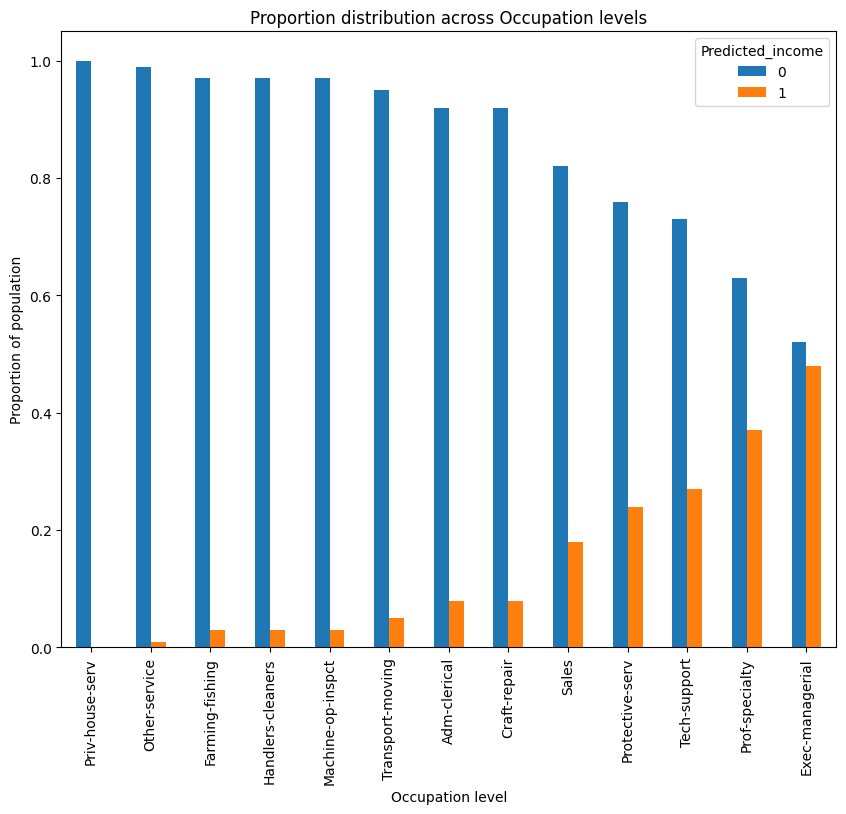

In [ ]:
# Occupation vs predicted income
occupation = round(pd.crosstab(df_new.occupation, df_new.Predicted_income).div(pd.crosstab(df_new.occupation, df_new.income).apply(sum,1),0),2)
occupation.sort_values(by = 1, inplace = True)
ax = occupation.plot(kind ='bar', title = 'Proportion distribution across Occupation levels', figsize = (10,8))
ax.set_xlabel('Occupation level')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

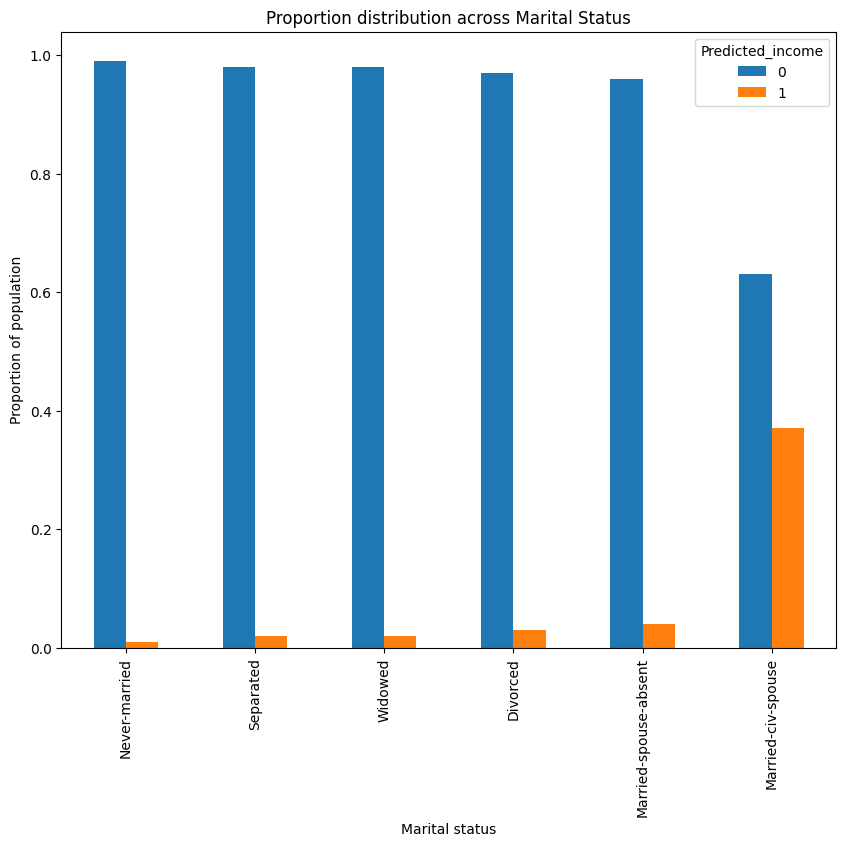

In [ ]:
# marital status vs predicted income
marital_status = round(pd.crosstab(df_new.marital_status, df_new.Predicted_income).div(pd.crosstab(df_new.marital_status, df_new.income).apply(sum,1),0),2)
marital_status.sort_values(by = 1, inplace = True)
ax = marital_status.plot(kind ='bar', title = 'Proportion distribution across Marital Status', figsize = (10,8))
ax.set_xlabel('Marital status')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

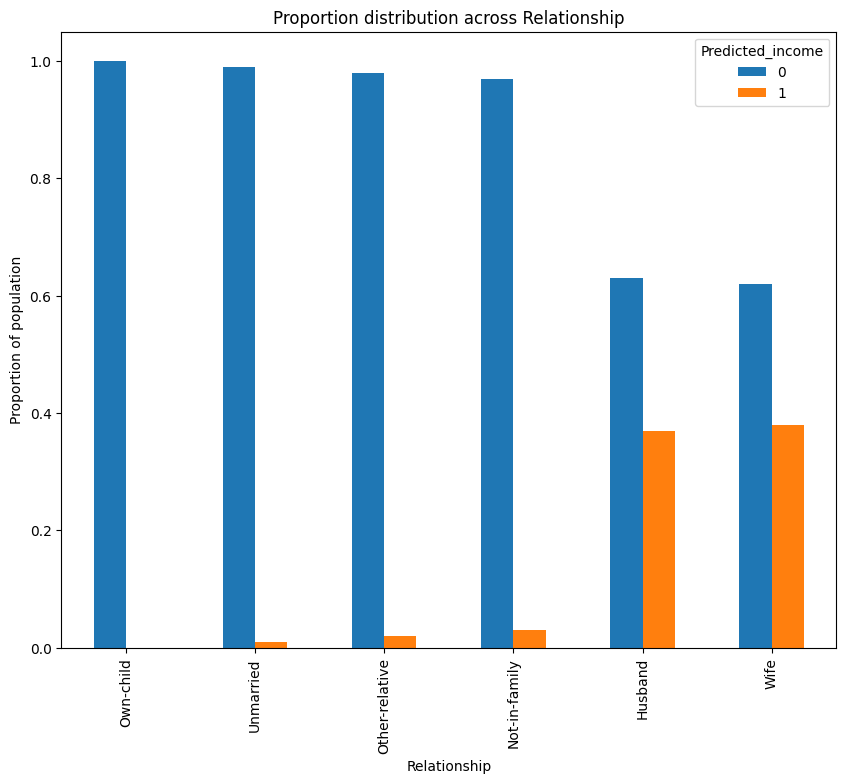

In [ ]:
# relationship vs predicted income
relationship = round(pd.crosstab(df_new.relationship, df_new.Predicted_income).div(pd.crosstab(df_new.relationship, df_new.income).apply(sum,1),0),2)
relationship.sort_values(by = 1, inplace = True)
ax = relationship.plot(kind ='bar', title = 'Proportion distribution across Relationship', figsize = (10,8))
ax.set_xlabel('Relationship')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

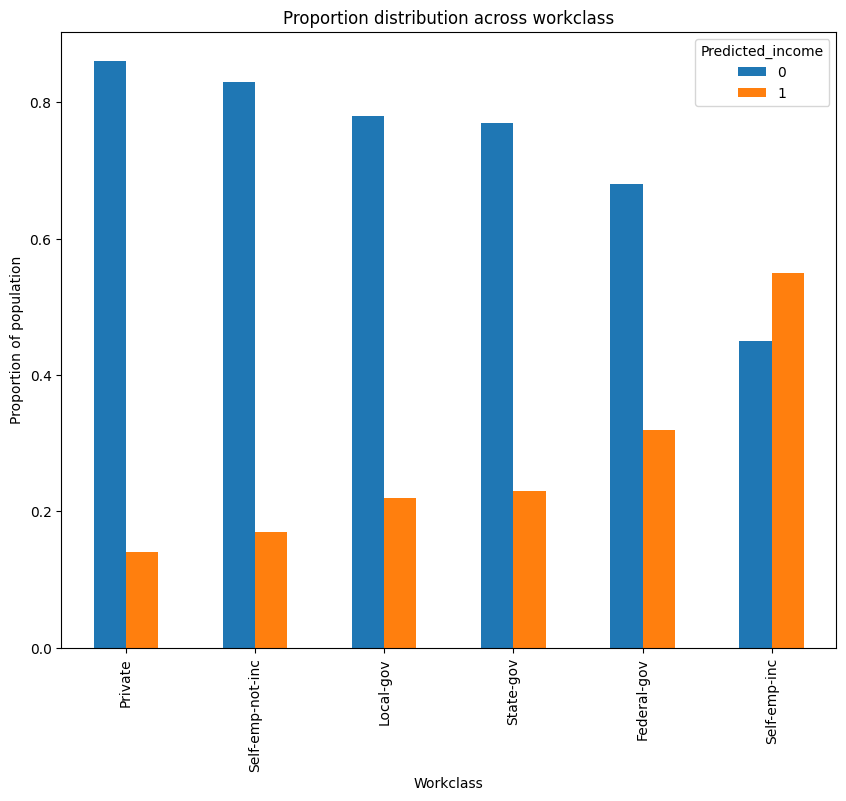

In [ ]:
# workclass vs predicted income
workclass = round(pd.crosstab(df_new.workclass, df_new.Predicted_income).div(pd.crosstab(df_new.workclass, df_new.income).apply(sum,1),0),2)
workclass.sort_values(by = 1, inplace = True)
ax = workclass.plot(kind ='bar', title = 'Proportion distribution across workclass', figsize = (10,8))
ax.set_xlabel('Workclass')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

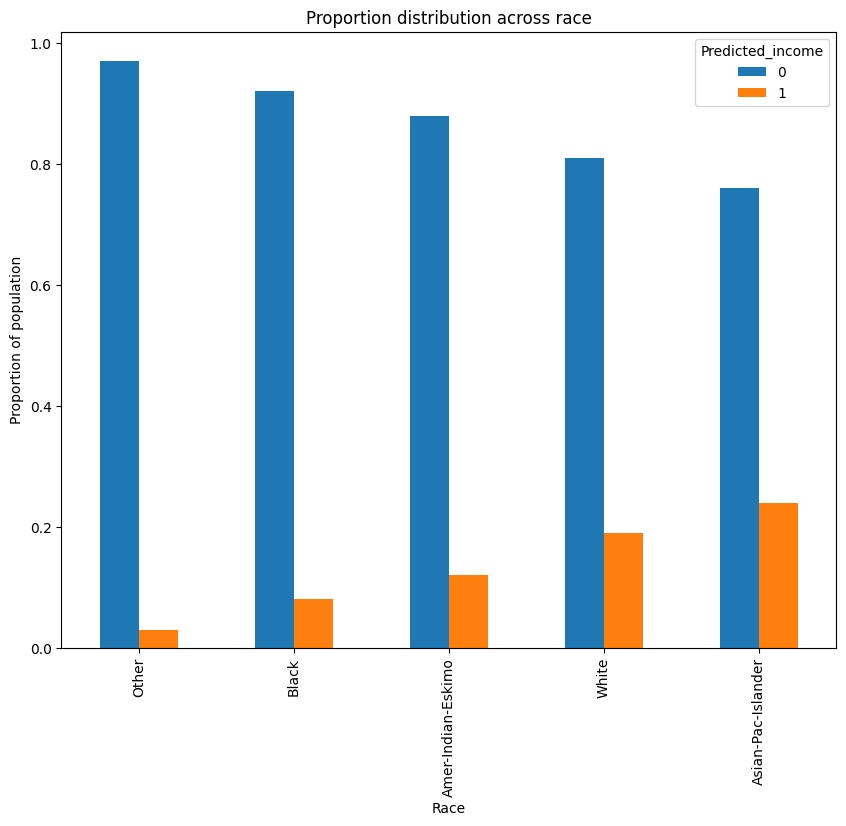

In [ ]:
# race vs predicted income
race = round(pd.crosstab(df_new.race, df_new.Predicted_income).div(pd.crosstab(df_new.race, df_new.income).apply(sum,1),0),2)
race.sort_values(by = 1, inplace = True)
ax = race.plot(kind ='bar', title = 'Proportion distribution across race', figsize = (10,8))
ax.set_xlabel('Race')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

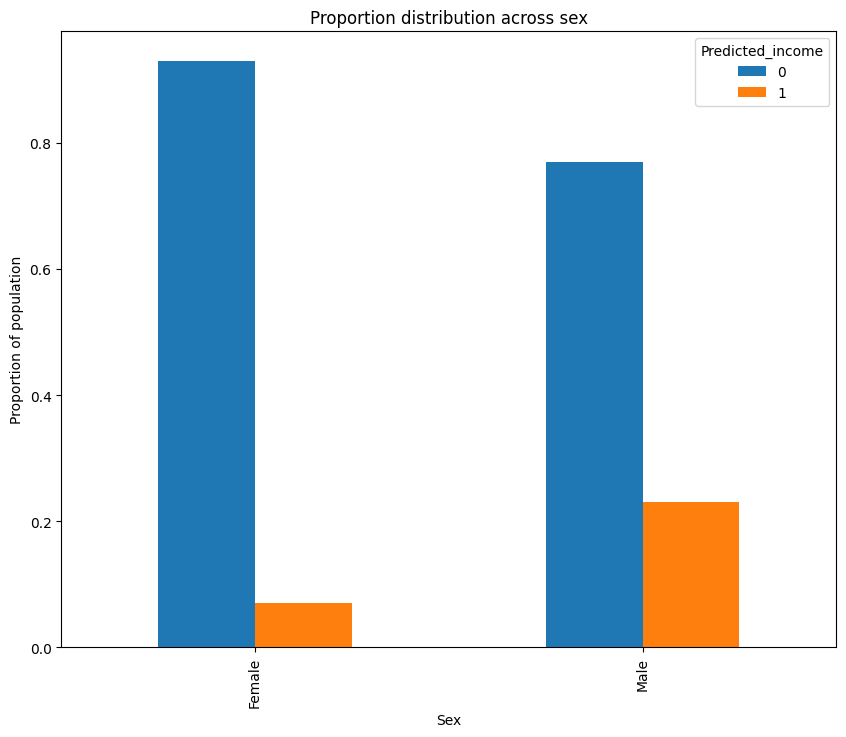

In [ ]:
# sex vs predicted income
sex = round(pd.crosstab(df_new.sex, df_new.Predicted_income).div(pd.crosstab(df_new.sex, df_new.income).apply(sum,1),0),2)
sex.sort_values(by = 1, inplace = True)
ax = sex.plot(kind ='bar', title = 'Proportion distribution across sex', figsize = (10,8))
ax.set_xlabel('Sex')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

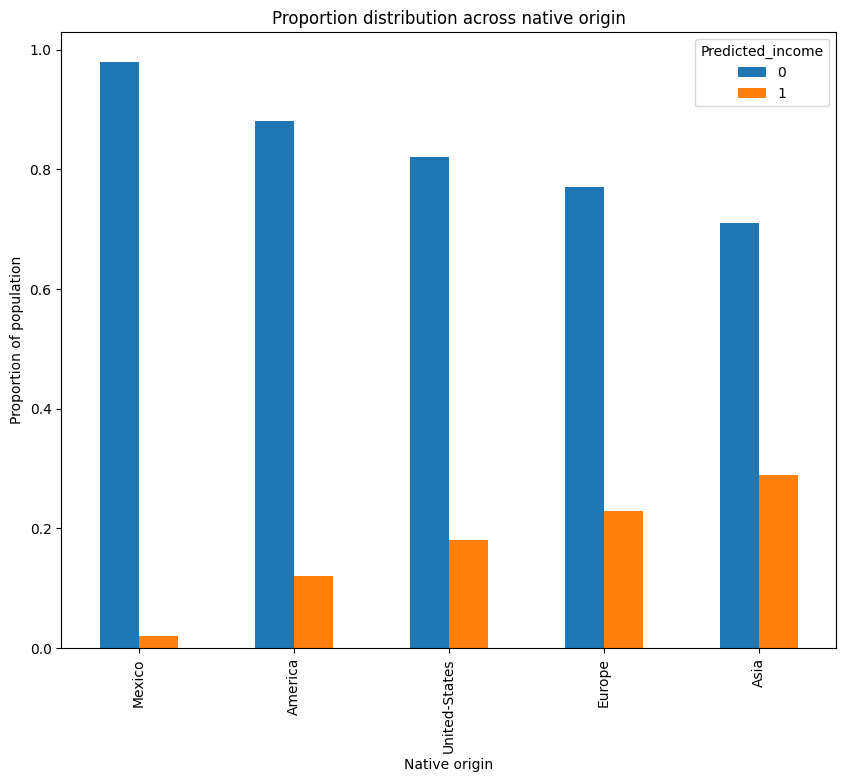

In [ ]:
# native origin vs predicted income
native_origin = round(pd.crosstab(df_new.native_origin, df_new.Predicted_income).div(pd.crosstab(df_new.native_origin, df_new.income).apply(sum,1),0),2)
native_origin.sort_values(by = 1, inplace = True)
ax = native_origin.plot(kind ='bar', title = 'Proportion distribution across native origin', figsize = (10,8))
ax.set_xlabel('Native origin')
ax.set_ylabel('Proportion of population')

Text(0, 0.5, 'Proportion of population')

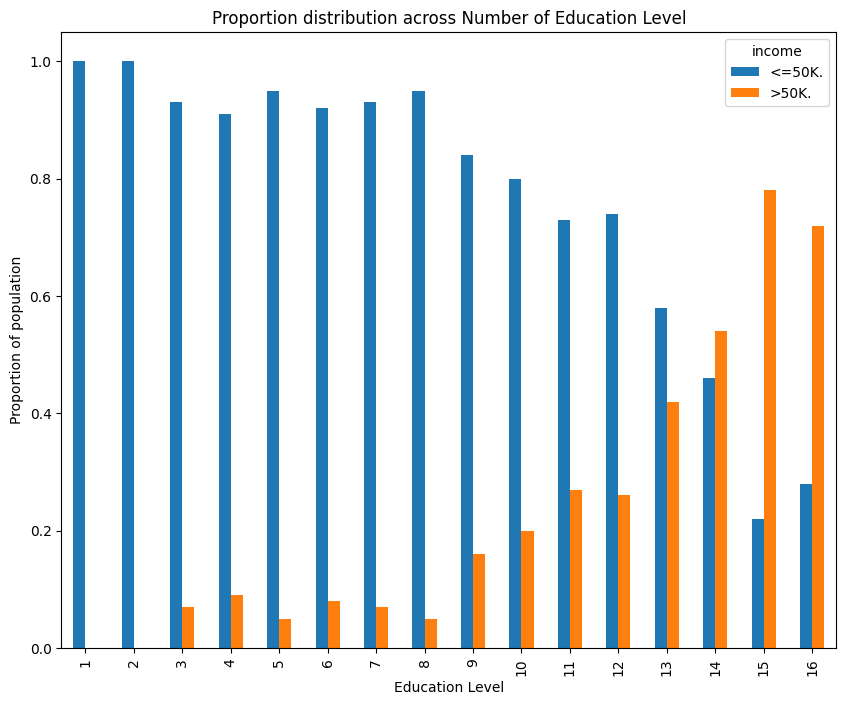

In [ ]:
# education vs predicted income
education_num = round(pd.crosstab(df_new['education_num'], df_new.income).div(pd.crosstab(df_new['education_num'], df_new.income).apply(sum,1),0),2)
ax = education_num.plot(kind ='bar', title = 'Proportion distribution across Number of Education Level', figsize = (10,8))
ax.set_xlabel('Education Level')
ax.set_ylabel('Proportion of population')

Based on the plots above, the top three categorical predictors associated with predicted income are:
- Occupation
- Education levels
- Work class

## **Step6: Numeric Predictors**
- the optimal model fitted by the entire `train_encoded` is called `optimal_model_entire`
- the optimal model fitted by partial `train_encoded` (X_train, y_train) is called `optimal_model`
- The available numeric predictors: age, demogweight, capital-net, hours-per-week

In [ ]:
#Extract weights
weights = optimal_model.layers[0].get_weights()[0]  # Weights from the first hidden layer
feature_importance = np.sum(np.abs(weights), axis=1)  # Sum of absolute weights for each feature

# Print feature importance
for i, importance in enumerate(feature_importance):
    print(f"Feature {i+1}: Importance {importance}")
    print(X_train.columns[i])

Feature 1: Importance 18.550180435180664
age
Feature 2: Importance 10.409364700317383
demogweight
Feature 3: Importance 15.140768051147461
education-num
Feature 4: Importance 12.0095796585083
hours-per-week
Feature 5: Importance 36.580108642578125
capital-net
Feature 6: Importance 11.489218711853027
workclass_Local-gov
Feature 7: Importance 8.194355964660645
workclass_Private
Feature 8: Importance 10.748800277709961
workclass_Self-emp-inc
Feature 9: Importance 11.101188659667969
workclass_Self-emp-not-inc
Feature 10: Importance 9.158215522766113
workclass_State-gov
Feature 11: Importance 9.2781982421875
marital-status_Married-civ-spouse
Feature 12: Importance 9.283801078796387
marital-status_Married-spouse-absent
Feature 13: Importance 8.622899055480957
marital-status_Never-married
Feature 14: Importance 9.628995895385742
marital-status_Separated
Feature 15: Importance 8.975238800048828
marital-status_Widowed
Feature 16: Importance 8.83625602722168
occupation_Craft-repair
Feature 17: I

In [ ]:
# SHAP explanation
explainer = shap.DeepExplainer(optimal_model, X_train)
shap_values = explainer.shap_values(X_train.values)

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:155: UserWarning: You have provided over 5k background samples! For better performance consider using smaller random sample.
  warnings.warn("You have provided over 5k background samples! For better performance consider using smaller random sample.")


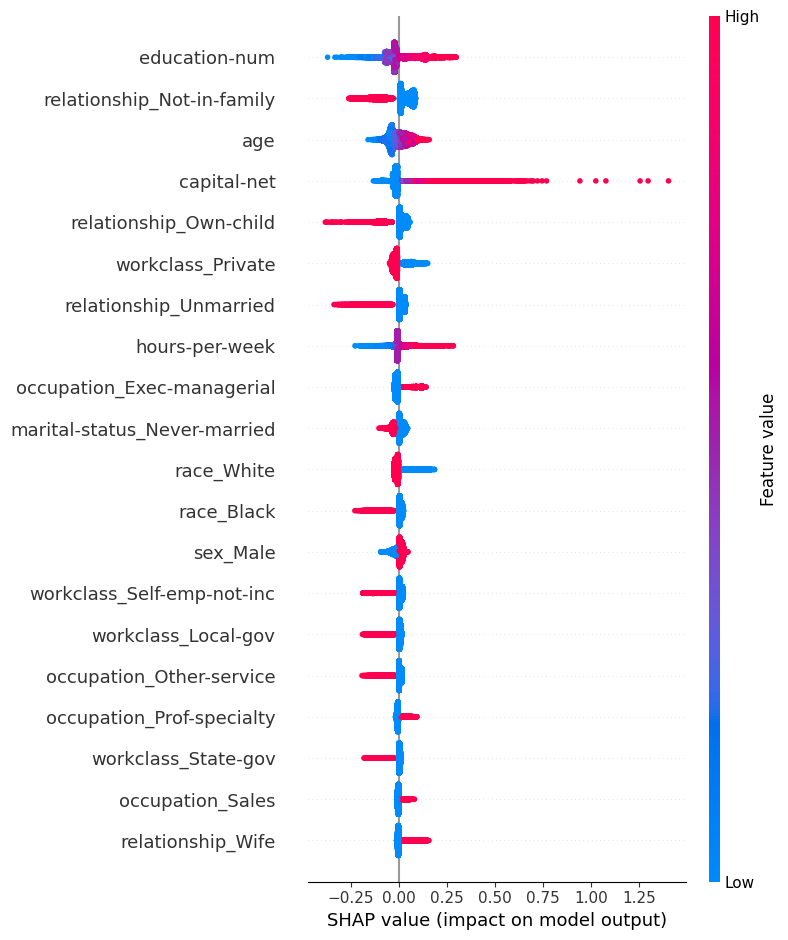

In [ ]:
feature_names=X_train.columns.tolist()
shap_values_matrix = np.array(shap_values).reshape(-1, len(feature_names))

# Generate SHAP summary plot
shap.summary_plot(shap_values_matrix, X_train, feature_names=feature_names)

In [ ]:
important_var = "capital_net"
unimportant_var = "demogweight"

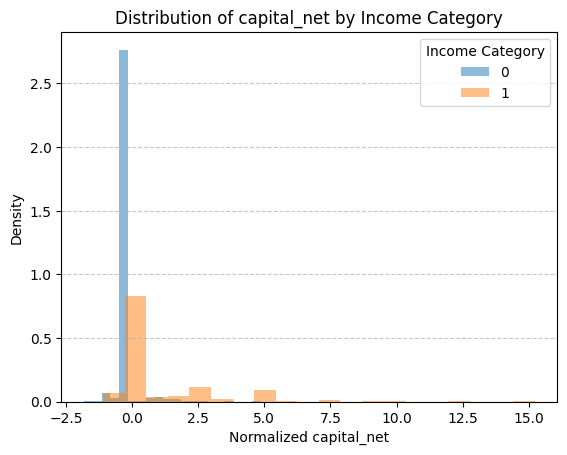

In [ ]:
def plot_histogram(variable, title,normalize=True):
    if normalize:
        normalized_values = (df_new[variable] - df_new[variable].mean()) / df_new[variable].std()
        df_new[f'{variable}_normalized'] = normalized_values
        variable_to_plot = f'{variable}_normalized'
    else:
        variable_to_plot = variable

    for income_group in df_new['Predicted_income'].unique():
        subset = df_new[df_new['Predicted_income'] == income_group]
        plt.hist(
            subset[variable_to_plot],
            bins=20,
            alpha=0.5,
            label=income_group,
            density=True
        )
    plt.title(title)
    plt.xlabel(f"{'Normalized ' if normalize else ''}{variable}")
    plt.ylabel("Density")
    plt.legend(title="Income Category")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
plot_histogram(important_var, f"Distribution of {important_var} by Income Category", normalize=True)

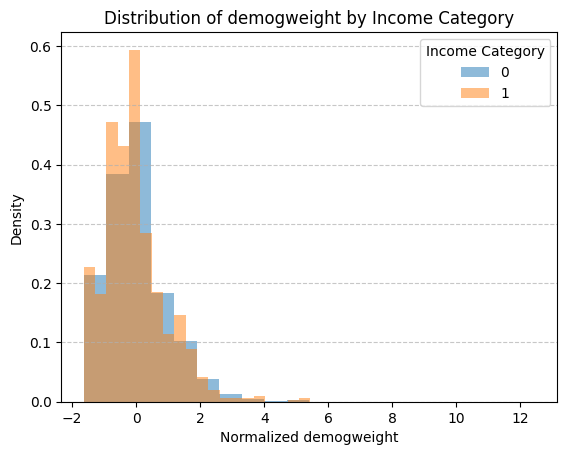

In [ ]:
plot_histogram(unimportant_var, f"Distribution of {unimportant_var} by Income Category",normalize=True)

## **Step7: Final Predictions on test_encoded**
- Use the optimal model fitted by the entire `train_encoded`
- The parameters used were selected by 5-fold cross validation under Step 2
-  predict using data from `test_encoded`.

In [ ]:
X = train_encoded.drop(columns=['income'])
y = train_encoded['income']
optimal_model.fit(X, y, epochs=20, batch_size=64)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8532 - loss: 0.3211
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8540 - loss: 0.3197
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8544 - loss: 0.3187
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8545 - loss: 0.3178
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8543 - loss: 0.3170
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8547 - loss: 0.3162
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8547 - loss: 0.3155
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8553 - loss: 0.3148
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8552 - loss: 0.3143
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8557 - loss: 0.3137
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8559 - loss: 0.3132
Epoch 12/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
y_pred = optimal_model_entire.predict(test_encoded)

# Convert probabilities to binary class labels (threshold = 0.5)
y_pred = (y_pred > 0.5).astype(int)

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


## **Step8: ASCII Predictions**

In [ ]:
file_name = "Finalpredictions.txt"
with open(file_name, "w") as file:
    for y in y_pred:
        file.write(f"{y[0]}\n")